In [ ]:
# Dataset: X-ray images of the hip joints - https://data.mendeley.com/datasets/zm6bxzhmfz/1

In [56]:
# %cd /content/drive/MyDrive
# %mkdir XrayHipJoints
# %cd XrayHipJoints

/content/drive/MyDrive
mkdir: cannot create directory ‘XrayHipJoints’: File exists
/content/drive/MyDrive/XrayHipJoints


In [1]:
%cd /content/drive/MyDrive/XrayHipJoints

/content/drive/MyDrive/XrayHipJoints


In [2]:
!pip install -q -U nibabel pytorch-lightning torchmetrics albumentations segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.0 MB/s eta 0:00:00


In [3]:
import os, torch, torchvision, torchmetrics, warnings

import numpy as np
import nibabel as nib
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp

from glob import glob
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from segmentation_models_pytorch.losses import DiceLoss

warnings.filterwarnings('ignore')
sns.set_style('dark')

In [4]:
# if not os.path.isfile('data.zip'):
#     !wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zm6bxzhmfz-1.zip -O data.zip

In [5]:
# if not os.path.isdir('data'):
#   with ZipFile('data.zip') as z:
#     z.extractall('data')

In [6]:
images = sorted(glob('./data/images/*.nii.gz'))
masks  = sorted(glob('./data/labels/*.nii.gz'))

data_dict = [{'image': image_name, 'mask': mask} for image_name, mask in zip(images, masks)]
data_dict[:5]

[{'image': './data/images/image_001.nii.gz',
  'mask': './data/labels/label_001.nii.gz'},
 {'image': './data/images/image_002.nii.gz',
  'mask': './data/labels/label_002.nii.gz'},
 {'image': './data/images/image_003.nii.gz',
  'mask': './data/labels/label_003.nii.gz'},
 {'image': './data/images/image_004.nii.gz',
  'mask': './data/labels/label_004.nii.gz'},
 {'image': './data/images/image_005.nii.gz',
  'mask': './data/labels/label_005.nii.gz'}]

In [7]:
train_set, val_set = train_test_split(data_dict, test_size=0.2, random_state=123)
train_set[0]

{'image': './data/images/image_043.nii.gz',
 'mask': './data/labels/label_043.nii.gz'}

(512, 324, 1) (512, 324, 1)
255.00000807456672 138.4742311527283
2.0 0.0


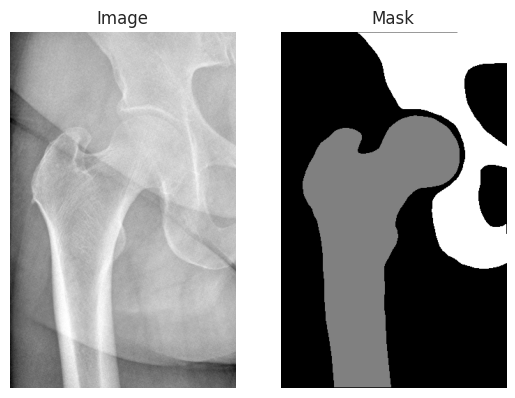

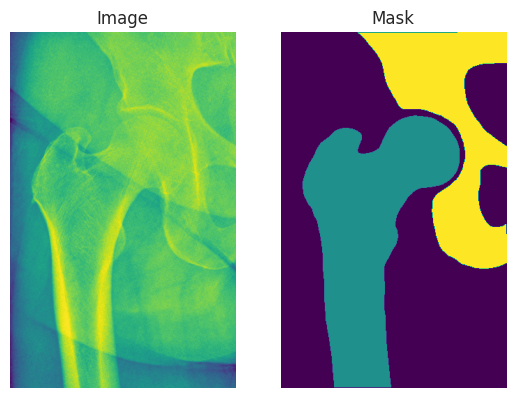

In [8]:
# Visualizing one sample
cmap = ['gray', 'viridis']

image = nib.load(train_set[0]['image']).get_fdata()
mask = nib.load(train_set[0]['mask']).get_fdata()

print(image.shape, mask.shape)
print(image.max(), image.min())
print(mask.max(), mask.min())

for _, c in enumerate(cmap):
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(np.squeeze(image, -1), cmap=c)
  ax[0].set_title('Image')
  ax[0].set_axis_off()

  ax[1].imshow(np.squeeze(mask, -1), cmap=c)
  ax[1].set_title('Mask')
  ax[1].set_axis_off()

In [9]:
IMG_SIZE = 512

train_aug = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                       A.Rotate(10),
                       A.GaussNoise(p=0.1),
                       A.Normalize(mean=(0),std=(1)),
                       ToTensorV2(p=1.0)])

val_aug = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                    A.Normalize(mean=(0), std=(1)),
                    ToTensorV2(p=1.0)])

In [10]:
class DataReader(Dataset):

    def __init__(self, data, transform):

        self.data = data
        self.transform = transform


    def __getitem__(self, index):

        image_path = self.data[index]['image']
        mask_path  = self.data[index]['mask']

        image = nib.load(image_path).get_fdata()
        mask  = nib.load(mask_path).get_fdata()

        transformed = self.transform(image=image, mask=mask)

        image = transformed['image']
        mask  = transformed['mask']

        mask = torch.moveaxis(mask, 2, 0)

        return image, mask


    def __len__(self):
        return len(self.data)

In [11]:
sample_data = DataReader(data_dict, train_aug)
sample_loader = DataLoader(sample_data, batch_size=4)
sample_batch = next(iter(sample_loader))

In [12]:
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

Text(0.5, 1.0, 'Batch of masks')

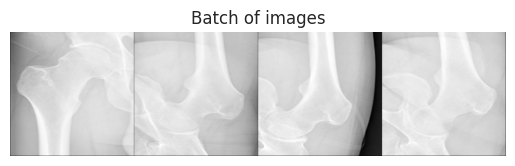

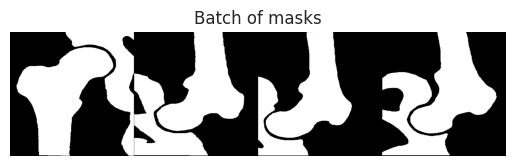

In [13]:
plt.figure()
grid_image = torchvision.utils.make_grid(sample_batch[0], 4, 1)
plt.imshow(grid_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Batch of images')

plt.figure()
grid_image = torchvision.utils.make_grid(sample_batch[1], 4, 1)
plt.imshow(grid_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Batch of masks')

In [14]:
class SegmentationClass(LightningModule):

    def __init__(self):
        super(SegmentationClass, self).__init__()

        # Architecture
        self.model = smp.UnetPlusPlus(encoder_name='resnet34',
                                      encoder_weights='imagenet',
                                      in_channels=1,
                                      classes=3)
        # params
        self.loss = DiceLoss(mode='multiclass', classes=3, from_logits=True)
        self.iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=3) # IoU
        self.batchsize = 24
        self.lr = 1e-3


    def forward(self, x):
        return self.model(x)


    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=1, eta_min=1e-5, last_epoch=-1)

        return {'optimizer': opt, 'lr_scheduler': scheduler}


    def train_dataloader(self):
        data = DataReader(train_set, train_aug)
        loader = DataLoader(data, batch_size=self.batchsize, shuffle=True)

        return loader


    def training_step(self, batch, batch_idx):
        image, mask = batch[0], torch.squeeze(batch[1], 1).long()
        pred = self(image)
        loss = self.loss(pred, mask)
        iou = self.iou(pred, mask)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss


    def val_dataloader(self):
        data = DataReader(val_set, val_aug)
        loader = DataLoader(data, batch_size=self.batchsize, shuffle=False)

        return loader


    def validation_step(self,batch,batch_idx):
        image, mask = batch[0], torch.squeeze(batch[1],1).long()
        pred = self(image)
        loss = self.loss(pred, mask)
        iou = self.iou(pred, mask)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss

In [15]:
model = SegmentationClass()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 85.1MB/s]


In [16]:
seed_everything(0)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = Trainer(max_epochs=50, accelerator='gpu', precision='16-mixed', callbacks=[lr_monitor])

trainer.fit(model)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | UnetPlusPlus           | 26.1 M
1 | loss  | DiceLoss               | 0     
2 | iou   | MulticlassJaccardIndex | 0     
-------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.291   Total estimated model params size

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [17]:
model = model.to('cuda')
test_loader = model.val_dataloader()
model.eval()

with torch.no_grad():

    imgs, preds, masks = [], [], []

    for img, mask in test_loader:
        pred = model(img.to('cuda'))
        pred = torch.sigmoid(pred)

        imgs.append(img)
        preds.append(pred)
        masks.append(mask)

In [18]:
imgs_array  = torch.cat(imgs)
preds_array = torch.cat(preds)
masks_array = torch.cat(masks)

imgs_array.shape, preds_array.shape, masks_array.shape

(torch.Size([28, 1, 512, 512]),
 torch.Size([28, 3, 512, 512]),
 torch.Size([28, 1, 512, 512]))

In [19]:
imgs_array  = torch.squeeze(imgs_array, dim=1)
preds_array = torch.argmax(preds_array, dim=1)
masks_array = torch.squeeze(masks_array, dim=1)

imgs_array.shape, preds_array.shape, masks_array.shape

(torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]))

In [20]:
preds_array_t = preds_array.cpu().numpy()

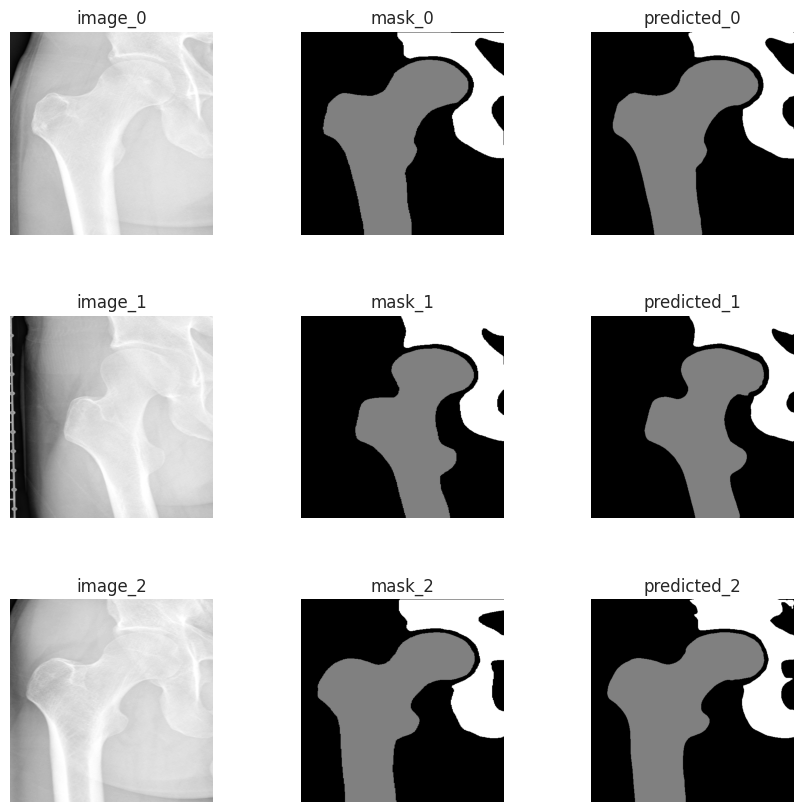

In [26]:
fig, ax = plt.subplots(3,3,figsize=(20,10))

for i in range(3):

  ax[i,0].imshow(imgs_array[i,:,:],cmap='gray')
  ax[i,0].set_axis_off()
  ax[i,0].set_title('image_{}'.format(i))

  ax[i,1].imshow(masks_array[i,:,:],cmap='gray')
  ax[i,1].set_axis_off()
  ax[i,1].set_title('mask_{}'.format(i))

  ax[i,2].imshow(preds_array_t[i,:,:],cmap='gray')
  ax[i,2].set_axis_off()
  ax[i,2].set_title('predicted_{}'.format(i))

plt.subplots_adjust(wspace=-0.7, hspace=0.4)